# Project 3: Collaboration and Competition. Tennis

---

### Preliminary actions

In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

from collections import deque
from unityagents import UnityEnvironment

from maddpg_agent import MADDGP_Agent

device: cpu


**IMPORTANT**: introduce in the following cell, the path to place where you have stored the file of the TENNIS evironment.

In [2]:
# Launching the environment
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Get and select the default brain
brain_names = env.brain_names
print('Number of available brains:',len(brain_names))
print('Name of the brains:',brain_names)

brain_name = brain_names[0]          # Get the name of the first brain
brain = env.brains[brain_name]       # Initizlize the brain
print(brain)

Number of available brains: 1
Name of the brains: ['TennisBrain']
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# Reset the environment
env_data = env.reset(train_mode=True)[brain_name]

# Number of agents in the environment
num_agents = len(env_data.agents)
print('Number of agents:', num_agents)

# size of the action space (per agent)
action_size = brain.vector_action_space_size
print('Size of action space (per agent):', action_size)

# Size fo the state space 
states = env_data.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state of any of the agents is made of 8 dimensions x 3 stacked observations = 24 values,')
print('and it looks likes this', states[0])

Number of agents: 2
Size of action space (per agent): 2
There are 2 agents. Each observes a state with length: 24
The state of any of the agents is made of 8 dimensions x 3 stacked observations = 24 values,
and it looks likes this [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Training the Agent with MADDPG algorithm

In [5]:
# Hyperparameters definition
hyperparameters = {
    'FC1': 190,               # Actor/Critic network: nodes at 1st hidden layer
    'FC2': 160,               # Actor/Critic network: nodes at 2nd hidden layer
    'BUFFER_SIZE': int(1e6),  # Replay buffer size
    'BATCH_SIZE': 256,        # Minibatch size
    'GAMMA': 0.99,            # Discount factor
    'TAU': 5e-3,              # For soft update of target parameters
    'LR_ACTOR': 1e-4,         # Learning rate of the actor
    'LR_CRITIC': 5e-4,        # Learning rate of the critic
    'WEIGHT_DECAY': 1e-6,     # Critic network L2 weight decay
    'UPDATE_EVERY': 1,        # Update rate
    'N_UPDATES': 1,           # Update passes
    'MU': 0.0,                # Parameter for Ornstein-Uhlenbeck noise
    'SIGMA': 0.20,            # Parameter for Ornstein-Uhlenbeck noise
    'THETA': 0.15,            # Parameter for Ornstein-Uhlenbeck noise
    'RANDOM_SEED': 4,         # Seed for random generation (to allow repetitiveness)
    'EPS_INT': 800            # Interval of episodes to decay de noise epsilon (from 1 to 0) 
     }

In [6]:
# Initializing the MADDPG agent (from maddpg_agent.py file)
agent = MADDGP_Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, 
                hyperparameters=hyperparameters)

In [7]:
# Defining the training process
def maddpg_training(agent, n_episodes=2000, print_every=100):
                                                # Initialize:
    scores_mean_log = []                        #      list for the log of mean scores
    scores_window = deque(maxlen=100)           #      list of last 100 scores
    scores = []                                 #      list containing score for each episode
    not_solved = True                           #      not_solved control
    solved_episode = 0                          #      episode for average score over threshold
    solved_av_score = 0                         #      average score when solved
    max_av_score = float("-inf")                #      maximum average score
    max_av_score_episode = 0                    #      episode at maximum average score
    
    
    for i_episode in range(1, n_episodes+1):                # Episode loop
        env_data = env.reset(train_mode=True)[brain_name]   # Reset environment in TRAINING MODE
        states = env_data.vector_observations               # Get the first state
        agent.reset()                                       # Reset smart agent (= noise process)
        
        score = np.zeros(num_agents)                        # Initialize score counter
        t = 1                                               # Initialize time step counter
        
        while True:                                         # Trajectory loop
            actions = agent.act(states, i_episode,
                                add_noise=True)             # Get actions from policy (one per agent)
            env_data = env.step(actions)[brain_name]        # Interaction with the environment
            
            next_states = env_data.vector_observations      # Get the next state (one per agent)
            rewards = env_data.rewards                      # Get the reward (one per agent)
            dones = env_data.local_done                     # Get the done code (one per agent)

            agent.step(states, actions, rewards, next_states, dones)   # Agents' process: gather experiences and learn
            
            score += rewards                               # Add time step reward to total trajectory score
            t += 1                                         # Update of time step counter
            
            if np.any(dones):                              # Break trajectory loop when episode finishes (done=True)
                break
                
            states = next_states                           # Roll over states for next iteration
    
        max_score = np.max(score)                          # Evaluate max score of the match from every agent's score
        scores.append(max_score)                           # Add max-agent score to score log
        scores_window.append(max_score)                    # Add max-agent score to last 100 scores log
        scores_mean_log.append(np.mean(scores_window))     # Add mean of the last 100 scores to the log of mean scores
        
        # Printing training log
        print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}\tScore: {}\tGame-steps: {:d} '
              .format(i_episode, np.mean(scores_window), max_score, score, t), end='')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\t                  \t                   \t                \t                '
                  .format(i_episode, np.mean(scores_window)))
        
        # Determination if problem solved
        if (np.mean(scores_window) >= 0.5) and not_solved:
            solved_episode = i_episode
            solved_av_score = np.mean(scores_window)
            not_solved = False
            
        # Saving agent and critic checkpoint files with every new max 100-last average socre
        if np.mean(scores_window) >= max_av_score:
            max_av_score = np.mean(scores_window)
            max_av_score_episode = i_episode
            for i in range(num_agents):
                torch.save(agent.ddpg_agents[i].actor_local.state_dict(), 'trained_actor_{:d}-maddpg.pth'.format(i))
                torch.save(agent.ddpg_agents[i].critic_local.state_dict(), 'trained_critic_{:d}-maddpg.pth'.format(i))
        
        # Stopping the learning process if no improvement in the last 200 episodes
        if not_solved == False and i_episode > (max_av_score_episode + 200) and np.mean(scores_window) < max_av_score:
            break
    
    # Printing summary
    print('\n')        
    print('Problem solved in {:d} episodes when reached an average score of {:.3f}'.format(solved_episode, solved_av_score))
    print('Maximum average score {:.3f}, reached at episode {:d}'.format(max_av_score, max_av_score_episode))
            
    return scores, scores_mean_log

Episode 100	Average Score: 0.000	                  	                   	                	                
Episode 200	Average Score: 0.011	                  	                   	                	                
Episode 300	Average Score: 0.023	                  	                   	                	                
Episode 400	Average Score: 0.074	                  	                   	                	                
Episode 500	Average Score: 0.102	                  	                   	                	                
Episode 600	Average Score: 0.099	                  	                   	                	                
Episode 700	Average Score: 0.110	                  	                   	                	                
Episode 800	Average Score: 0.122	                  	                   	                	                
Episode 900	Average Score: 0.154	                  	                   	                	                
Episode 1000	Average Score: 0.240	            

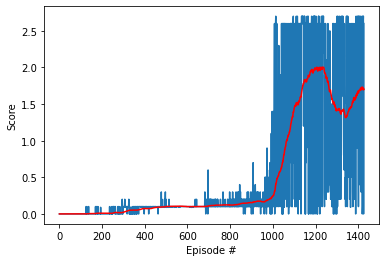

In [8]:
# Lauching the training process
scores, scores_mean_log = maddpg_training(agent, n_episodes=3000)

# Ploting the scores evolution during training.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='episode max s')
plt.plot(np.arange(1, len(scores)+1), scores_mean_log, c='r', label='100-last-score mean')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Checking agent performance

In [9]:
# Load actor and critic weights from file (if needed)
#agent = MADDGP_Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, 
#                hyperparameters=hyperparameters)

#for i in range(num_agents):
#    agent.ddpg_agents[i].actor_local.load_state_dict(torch.load('trained_actor_{:d}-maddpg.pth'.format(i)))
#    agent.ddpg_agents[i].critic_local.load_state_dict(torch.load('trained_critic_{:d}-maddpg.pth'.format(i)))

In [10]:
# Checking the performance of the trained agent
scores_log = []
test_episodes = 5

for i in range(0, test_episodes):                          # play game for a number of episodes

    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)

    while True:                                            # play loop
        actions = agent.act(states, i, add_noise=False)       # get actions from trained agent
        env_data = env.step(actions)[brain_name]           # interact with the environment
        
        next_states = env_data.vector_observations         # get next state (for each agent)
        rewards = env_data.rewards                         # get reward (for each agent)
        dones = env_data.local_done                        # see if episode finished
        
        scores += env_data.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    scores_log.append(np.max(scores))
    
    print('Score (max over agents) at episode {:d}: {:2f}'.format(i+1, np.max(scores)))


print('\nSmart Agent average score after {:d} episodes: {:.2f}'.format(test_episodes, np.mean(scores_log)))

Score (max over agents) at episode 1: 2.700000
Score (max over agents) at episode 2: 2.600000
Score (max over agents) at episode 3: 2.700000
Score (max over agents) at episode 4: 2.600000
Score (max over agents) at episode 5: 2.700000

Smart Agent average score after 5 episodes: 2.66


In [11]:
# Checking the performance of the random agent
scores_log = []
test_episodes = 5

for i in range(0, test_episodes):                          # play game for a number of episodes
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)

    while True:                                            # play loop
        actions = np.random.randn(num_agents, action_size) # get random actions (for each agent)
        actions = np.clip(actions, -1, 1)                  # clip all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # interact with the environment
        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    scores_log.append(np.max(scores))
    
    print('Score (max over all agents) at episode {:d}: {:2f}'.format(i+1, np.max(scores)))
    
print('\nAverage score after {:d} episodes: {:2f}'.format(test_episodes, np.mean(scores_log)))

Score (max over all agents) at episode 1: 0.000000
Score (max over all agents) at episode 2: 0.100000
Score (max over all agents) at episode 3: 0.000000
Score (max over all agents) at episode 4: 0.000000
Score (max over all agents) at episode 5: 0.090000

Average score after 5 episodes: 0.038000


### Closing the environment

In [12]:
# Close the environment
env.close()